In [ ]:
from google.colab import drive
drive.mount("/content/contentdrive/")

Mounted at /content/contentdrive/


In [ ]:
%cd /content/contentdrive/MyDrive/Final_Capstone_Project

/content/contentdrive/MyDrive/Final_Capstone_Project


In [ ]:
# Load the models
from imblearn.ensemble import BalancedRandomForestClassifier
from tensorflow.keras.models import load_model
import pandas as pd
import joblib


In [ ]:
# Load the datasets for A/B testing
X_bootstrap_1 = pd.read_pickle('bootstrap_X_test_set_1.pkl')
y_bootstrap_1 = pd.read_pickle('bootstrap_y_test_set_1.pkl')

X_bootstrap_2 = pd.read_pickle('bootstrap_X_test_set_2.pkl')
y_bootstrap_2 = pd.read_pickle('bootstrap_y_test_set_2.pkl')

X_bootstrap_3 = pd.read_pickle('bootstrap_X_test_set_3.pkl')
y_bootstrap_3 = pd.read_pickle('bootstrap_y_test_set_3.pkl')

# Load the Balanced Random Forest (BRF) predictions
brf_train_pred_df = pd.read_csv('brf_train_predictions.csv')
brf_test_pred_df = pd.read_csv('brf_test_predictions.csv')

# Load the Deep Neural Network (DNN) predictions
dnn_train_pred_df = pd.read_csv('dnn_train_predictions.csv')
dnn_test_pred_df = pd.read_csv('dnn_test_predictions.csv')

# Load the column names of X
X_columns = pd.read_csv('X_columns.csv', header=None)

# Load the predictions for Balanced Random Forest
brf_train_pred_df = pd.read_csv('brf_train_predictions.csv')
brf_test_pred_df = pd.read_csv('brf_test_predictions.csv')

# Load the predictions for Deep Neural Network
dnn_train_pred_df = pd.read_csv('dnn_train_predictions.csv')
dnn_test_pred_df = pd.read_csv('dnn_test_predictions.csv')


In [ ]:
# Load the Balanced Random Forest model
brf_model = joblib.load('balanced_random_forest_model.pkl')

# Load the Deep Neural Network model
dnn_model = load_model('deep_neural_network_model.keras')

In [ ]:
# Load the training and test datasets
X_train = pd.read_csv('X_train_data.csv')
y_train = pd.read_csv('y_train_data.csv')
X_test = pd.read_csv('X_test_data.csv')
y_test = pd.read_csv('y_test_data.csv')

# **A/B Testing**

In [ ]:
# Cell 1: Model Evaluation Function
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from scipy.stats import ttest_rel, wilcoxon, mannwhitneyu

# Function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)

    # If using a DNN with sigmoid output, apply threshold to get binary predictions
    if len(predictions.shape) > 1 and predictions.shape[1] == 1:
        predictions = (predictions > 0.5).astype(int)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    auc_roc = roc_auc_score(y_test, predictions)

    return accuracy, f1, precision, recall, auc_roc

# Prepare to store results
results = {
    'Set': [],
    'Model': [],
    'Accuracy': [],
    'F1 Score': [],
    'Precision': [],
    'Recall': [],
    'AUC-ROC': []
}

# Store performance metrics for statistical tests
brf_metrics = {'Accuracy': [], 'F1 Score': [], 'Precision': [], 'Recall': [], 'AUC-ROC': []}
dnn_metrics = {'Accuracy': [], 'F1 Score': [], 'Precision': [], 'Recall': [], 'AUC-ROC': []}

# Iterate through the three bootstrap test sets
for i in range(1, 4):
    # Load the bootstrap test set
    X_bootstrap = pd.read_pickle(f'bootstrap_X_test_set_{i}.pkl')
    y_bootstrap = pd.read_pickle(f'bootstrap_y_test_set_{i}.pkl')

    # Evaluate the Balanced Random Forest model
    brf_results = evaluate_model(brf_model, X_bootstrap, y_bootstrap)
    results['Set'].append(f'Set {i}')
    results['Model'].append('Balanced Random Forest')
    results['Accuracy'].append(brf_results[0])
    results['F1 Score'].append(brf_results[1])
    results['Precision'].append(brf_results[2])
    results['Recall'].append(brf_results[3])
    results['AUC-ROC'].append(brf_results[4])

    # Store metrics for statistical analysis
    for metric, value in zip(brf_metrics.keys(), brf_results):
        brf_metrics[metric].append(value)

    # Evaluate the Deep Neural Network model
    dnn_results = evaluate_model(dnn_model, X_bootstrap, y_bootstrap)
    results['Set'].append(f'Set {i}')
    results['Model'].append('Deep Neural Network')
    results['Accuracy'].append(dnn_results[0])
    results['F1 Score'].append(dnn_results[1])
    results['Precision'].append(dnn_results[2])
    results['Recall'].append(dnn_results[3])
    results['AUC-ROC'].append(dnn_results[4])

    # Store metrics for statistical analysis
    for metric, value in zip(dnn_metrics.keys(), dnn_results):
        dnn_metrics[metric].append(value)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
results_df

,Set,Model,Accuracy,F1 Score,Precision,Recall,AUC-ROC
0,Set 1,Balanced Random Forest,0.998533,0.998545,1.000000,0.997094,0.998547
1,Set 1,Deep Neural Network,0.995867,0.995888,1.000000,0.991810,0.995905
2,Set 2,Balanced Random Forest,0.998600,0.998570,1.000000,0.997144,0.998572
3,Set 2,Deep Neural Network,0.995733,0.995630,0.999589,0.991703,0.995655
4,Set 3,Balanced Random Forest,0.998333,0.998318,1.000000,0.996641,0.998321
5,Set 3,Deep Neural Network,0.996067,0.996022,0.999729,0.992342,0.996039


In [ ]:
import plotly.graph_objects as go

# Define a color map for each model
model_colors = {
    'Balanced Random Forest': 'green',
    'Deep Neural Network': 'orange'
}

# Metrics to be visualized
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']

# Plot for each metric
for metric in metrics:
    fig = go.Figure()

    for model in results_df['Model'].unique():  # Get unique models
        for i in range(1, 4):  # Iterate through the three sets
            # Filter the results for the current model, metric, and set
            value = results_df.loc[(results_df['Model'] == model) & (results_df['Set'] == f'Set {i}'), metric].values[0] * 100

            fig.add_trace(
                go.Bar(
                    x=[f"{model} - Set {i}"],
                    y=[value],
                    text=[f'{value:.2f}%'],
                    textposition='auto',
                    name=f"{model} - Set {i}",
                    marker_color=model_colors.get(model, 'gray')  # Assign color to each model or default to gray
                )
            )

    fig.update_layout(
        title=f"{metric} Comparison Across Models and Sets",
        yaxis_title=f"{metric} (%)",
        xaxis_title="Models and Sets",
        xaxis=dict(
            tickvals=[],  # Hide x-axis ticks
            ticktext=[]   # Hide x-axis labels
        ),
        template='plotly_white',
        height=400,
        width=1200,
        showlegend=True
    )

    # Show the plot for the current metric
    fig.show()


#1. **Paired t-test**
Null Hypothesis (H0): There is no significant difference in the mean performance metric between the Balanced Random Forest and the Deep Neural Network.

Alternative Hypothesis (H1): There is a significant difference in the mean performance metric between the Balanced Random Forest and the Deep Neural Network.

In [ ]:
# Cell 2: Paired t-test
statistical_results_ttest = {
    'Metric': [],
    't-statistic': [],
    'p-value (t-test)': []
}

# Iterate through each metric for the paired t-test
for metric in brf_metrics.keys():
    brf_values = np.array(brf_metrics[metric])
    dnn_values = np.array(dnn_metrics[metric])

    # Paired t-test
    t_stat, p_ttest = ttest_rel(brf_values, dnn_values)

    # Store results
    statistical_results_ttest['Metric'].append(metric)
    statistical_results_ttest['t-statistic'].append(t_stat)
    statistical_results_ttest['p-value (t-test)'].append(p_ttest)

# Convert statistical results to a DataFrame
statistical_results_ttest_df = pd.DataFrame(statistical_results_ttest)

# Display statistical results for t-test
print("Paired t-test Results:")
print(statistical_results_ttest_df)


Paired t-test Results:
      Metric  t-statistic  p-value (t-test)
0   Accuracy    14.740614          0.004571
1   F1 Score    14.123548          0.004976
2  Precision     1.883544          0.200317
3     Recall    14.019689          0.005049
4    AUC-ROC    14.226008          0.004905


# **2. Wilcoxon Signed-Rank Test**
Null Hypothesis (H0): There is no significant difference in the median performance metric between the Balanced Random Forest and the Deep Neural Network.


Alternative Hypothesis (H1): There is a significant difference in the median performance metric between the Balanced Random Forest and the Deep Neural Network.

In [ ]:
# Cell 3: Wilcoxon signed-rank test
statistical_results_wilcoxon = {
    'Metric': [],
    'W-statistic (Wilcoxon)': [],
    'p-value (Wilcoxon)': []
}

# Iterate through each metric for the Wilcoxon signed-rank test
for metric in brf_metrics.keys():
    brf_values = np.array(brf_metrics[metric])
    dnn_values = np.array(dnn_metrics[metric])

    # Wilcoxon signed-rank test
    w_stat, p_wilcoxon = wilcoxon(brf_values, dnn_values)

    # Store results
    statistical_results_wilcoxon['Metric'].append(metric)
    statistical_results_wilcoxon['W-statistic (Wilcoxon)'].append(w_stat)
    statistical_results_wilcoxon['p-value (Wilcoxon)'].append(p_wilcoxon)

# Convert statistical results to a DataFrame
statistical_results_wilcoxon_df = pd.DataFrame(statistical_results_wilcoxon)

# Display statistical results for Wilcoxon test
print("Wilcoxon Signed-Rank Test Results:")
print(statistical_results_wilcoxon_df)


Wilcoxon Signed-Rank Test Results:
      Metric  W-statistic (Wilcoxon)  p-value (Wilcoxon)
0   Accuracy                     0.0            0.250000
1   F1 Score                     0.0            0.250000
2  Precision                     0.0            0.179712
3     Recall                     0.0            0.250000
4    AUC-ROC                     0.0            0.250000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


# **3 .Mann-Whitney U Test**
Null Hypothesis (H0): The distributions of the performance metrics for the Balanced Random Forest and the Deep Neural Network are equal.


Alternative Hypothesis (H1): The distributions of the performance metrics for the Balanced Random Forest and the Deep Neural Network are not equal.

In [ ]:
# Cell 4: Mann-Whitney U test
statistical_results_mannwhitney = {
    'Metric': [],
    'U-statistic (Mann-Whitney)': [],
    'p-value (Mann-Whitney)': []
}

# Iterate through each metric for the Mann-Whitney U test
for metric in brf_metrics.keys():
    brf_values = np.array(brf_metrics[metric])
    dnn_values = np.array(dnn_metrics[metric])

    # Mann-Whitney U test
    u_stat, p_mannwhitney = mannwhitneyu(brf_values, dnn_values)

    # Store results
    statistical_results_mannwhitney['Metric'].append(metric)
    statistical_results_mannwhitney['U-statistic (Mann-Whitney)'].append(u_stat)
    statistical_results_mannwhitney['p-value (Mann-Whitney)'].append(p_mannwhitney)

# Convert statistical results to a DataFrame
statistical_results_mannwhitney_df = pd.DataFrame(statistical_results_mannwhitney)

# Display statistical results for Mann-Whitney U test
print("Mann-Whitney U Test Results:")
print(statistical_results_mannwhitney_df)


Mann-Whitney U Test Results:
      Metric  U-statistic (Mann-Whitney)  p-value (Mann-Whitney)
0   Accuracy                         9.0                0.100000
1   F1 Score                         9.0                0.100000
2  Precision                         7.5                0.196706
3     Recall                         9.0                0.100000
4    AUC-ROC                         9.0                0.100000


Statistical Results:

Paired t-test: The t-statistic is significant for metrics like Accuracy, F1 Score, Recall, and AUC-ROC (with p-values less than 0.05). However, Precision does not show significance (p = 0.200317). This indicates that the Balanced Random Forest (BRF) model has better performance in these areas compared to the Deep Neural Network (DNN).
Wilcoxon Signed-Rank Test: The results showed no significant differences across all metrics, indicating that the performance differences may not be consistent or robust.
Mann-Whitney U Test: Similarly, the results indicated no significant differences in any of the metrics.
Performance Metrics:

Since the t-test shows statistical significance for several metrics, you may lean towards saying the BRF model outperforms the DNN model in terms of Accuracy, F1 Score, Recall, and AUC-ROC.
However, given that the other tests did not show significant differences, you should consider the practical implications and the context of the problem when making a conclusion.
Conclusion
Balanced Random Forest (BRF): Based on the significant t-test results, you can assert that the BRF model is performing better in terms of the Accuracy, F1 Score, Recall, and AUC-ROC metrics.

# **Balanced Random Forest Explainable AI**

In [ ]:
!pip install shap
!pip install lime

In [ ]:
import shap
import numpy as np
import pandas as pd
import lime
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

In [ ]:
from sklearn.utils import resample
# Ensure that you have at least 25,000 records in your datasets before bootstrapping
desired_sample_size = 25000

# Bootstrapping for X_train
X_train_sample = resample(X_train, n_samples=desired_sample_size, replace=True, random_state=42)
y_train_sample = resample(y_train, n_samples=desired_sample_size, replace=True, random_state=42)
desired_sample_size = 15000
# Bootstrapping for X_test
X_test_sample = resample(X_test, n_samples=desired_sample_size, replace=True, random_state=42)
y_test_sample = resample(y_test, n_samples=desired_sample_size, replace=True, random_state=42)

# Verify the sizes of the new samples
print("Bootstrapped X_train_sample shape:", X_train_sample.shape)
print("Bootstrapped y_train_sample shape:", y_train_sample.shape)
print("Bootstrapped X_test_sample shape:", X_test_sample.shape)
print("Bootstrapped y_test_sample shape:", y_test_sample.shape)


Bootstrapped X_train_sample shape: (40000, 34)
Bootstrapped y_train_sample shape: (40000, 1)
Bootstrapped X_test_sample shape: (40000, 34)
Bootstrapped y_test_sample shape: (40000, 1)


100%|===================| 147901/148206 [08:05<00:01]       

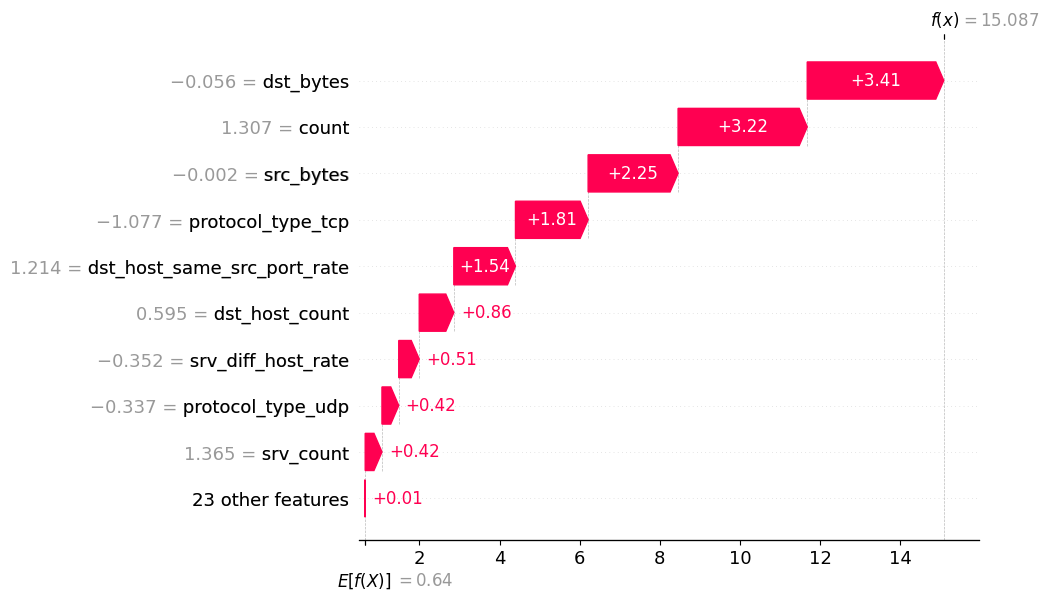

In [ ]:
# Load the feature names from X_columns.csv
feature_names = X_columns.squeeze().tolist()

# Create a SHAP explainer for the Balanced Random Forest model
explainer = shap.TreeExplainer(brf_model)

# Calculate SHAP values for the bootstrapped test dataset
shap_values = explainer.shap_values(X_test_sample)

# Summary plot of SHAP values for feature importance
shap.summary_plot(shap_values[1], X_test_sample, feature_names=feature_names)

# Plot SHAP values for a single prediction (first prediction in the bootstrapped test set)
shap.plots.waterfall(shap_values[1][0])

# Initialize the JavaScript visualizer
shap.initjs()

# Force plot for the first prediction, with the loaded feature names
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test_sample.iloc[0,:], feature_names=feature_names)


In [ ]:
# Create a DataFrame to hold mean SHAP values for the positive class
shap_values_mean = np.abs(shap_values[1]).mean(axis=0)  # For the positive class (index 1)

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Mean SHAP Value': shap_values_mean})

# Sort by Mean SHAP Value
importance_df = importance_df.sort_values(by='Mean SHAP Value', ascending=False)

# Display mean SHAP values
print(importance_df)


                        Feature  Mean SHAP Value
2                     dst_bytes         2.308186
11                        count         2.012103
1                     src_bytes         1.835309
30            protocol_type_tcp         1.232470
24  dst_host_same_src_port_rate         0.922411
27     dst_host_srv_serror_rate         0.483840
20               dst_host_count         0.415797
31            protocol_type_udp         0.413229
21           dst_host_srv_count         0.405994
12                    srv_count         0.272201
19           srv_diff_host_rate         0.245145
13                  serror_rate         0.234407
22       dst_host_same_srv_rate         0.220115
25  dst_host_srv_diff_host_rate         0.182055
23       dst_host_diff_srv_rate         0.155554
29     dst_host_srv_rerror_rate         0.134808
26         dst_host_serror_rate         0.127060
17                same_srv_rate         0.113308
28         dst_host_rerror_rate         0.111373
15                  

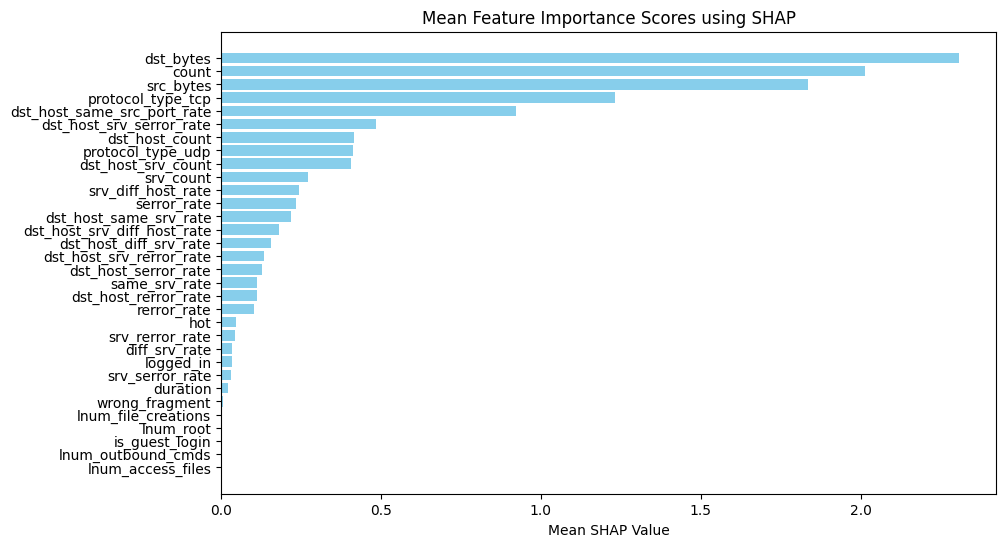

In [ ]:
# Optionally, visualize the mean SHAP values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Mean SHAP Value'], color='skyblue')
plt.xlabel('Mean SHAP Value')
plt.title('Mean Feature Importance Scores using SHAP')
plt.gca().invert_yaxis()  # Invert y axis to show the most important features on top
plt.show()

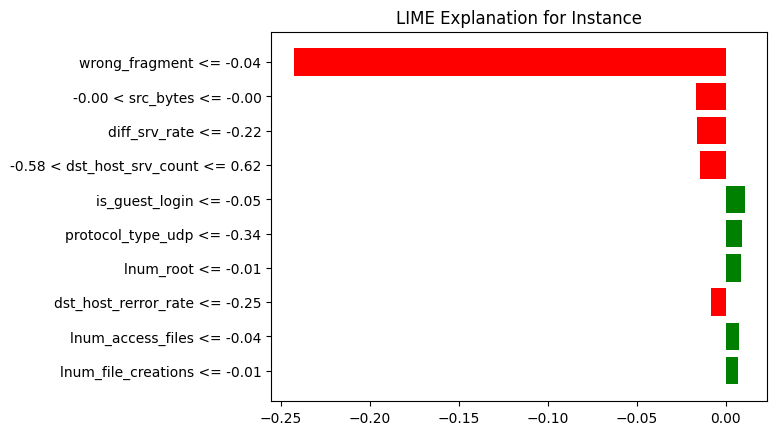

In [ ]:
# Set up the LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train_sample,  # Use the bootstrapped training data
    feature_names=feature_names,
    class_names=['Benign', 'Attack'],  # Adjust class names based on your labels
    mode='classification'
)

# Define a wrapper function to return probabilities for both classes
def predict_proba(X):
    return brf_model.predict_proba(X)

# Select an instance to explain from the bootstrapped test data
instance_to_explain = X_test_sample.iloc[0].values.reshape(1, -1)  # Ensure it is 2D for prediction

# Explain the instance
explanation = explainer.explain_instance(
    instance_to_explain[0],
    predict_proba,  # Use the adjusted prediction function
    num_features=10  # Number of features to display
)

# Visualize the explanation in the notebook
explanation.show_in_notebook(show_table=True, show_all=False)

# Alternatively, visualize the explanation using matplotlib
fig = explanation.as_pyplot_figure()
plt.title("LIME Explanation for Instance")
plt.show()


Unique labels in y_test: [0 1]
LIME Explanation for Normal Case:


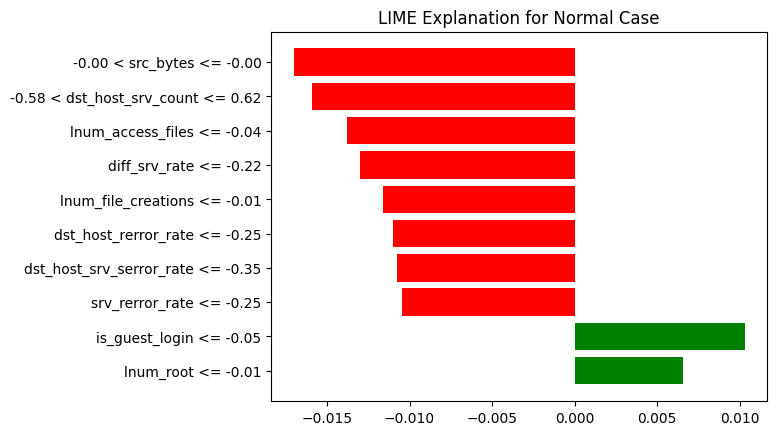

LIME Explanation for Abnormal Case:


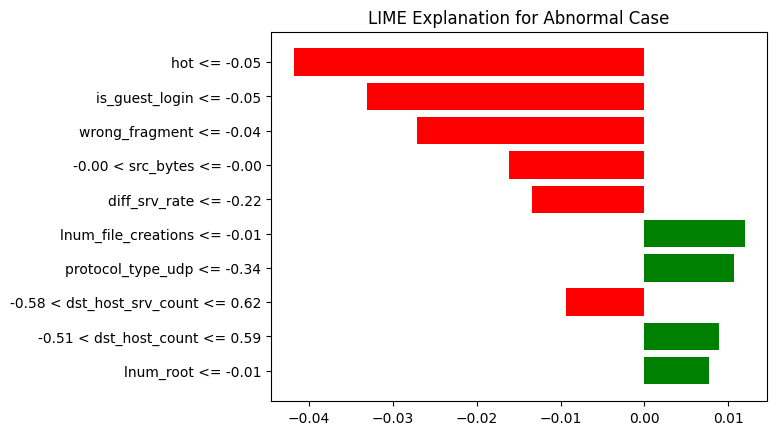

In [ ]:
# Create the LIME explainer
explainer = LimeTabularExplainer(X_train_scaled,  # Use the scaled training data
                                   feature_names=feature_names,
                                   class_names=['Normal Traffic', 'Abnormal Traffic'],
                                   discretize_continuous=True)

# Function to visualize LIME explanation and plot
def visualize_lime_explanation(instance, title):
    exp = explainer.explain_instance(instance.flatten(), gb_model.predict_proba)

    # Show the explanation as a plot
    fig = exp.as_pyplot_figure()
    plt.title(title)
    plt.show()

# Check unique values in y_test
print("Unique labels in y_test:", np.unique(y_test))

# Visualize for a Normal case if it exists
normal_indices = np.where(y_test == 0)[0]  # '0' is for Normal Traffic
if normal_indices.size > 0:
    normal_case_index = normal_indices[0]
    normal_instance = X_test_scaled[normal_case_index].reshape(1, -1)  # Use scaled data
    print("LIME Explanation for Normal Case:")
    visualize_lime_explanation(normal_instance, "LIME Explanation for Normal Case")  # Added title argument
else:
    print("No instances of Normal Traffic found in y_test.")

# Visualize for an Abnormal case if it exists
abnormal_indices = np.where(y_test == 1)[0]  # '1' is for Abnormal Traffic
if abnormal_indices.size > 0:
    abnormal_case_index = abnormal_indices[0]
    abnormal_instance = X_test_scaled[abnormal_case_index].reshape(1, -1)  # Use scaled data
    print("LIME Explanation for Abnormal Case:")
    visualize_lime_explanation(abnormal_instance, "LIME Explanation for Abnormal Case")  # Added title argument
else:
    print("No instances of Abnormal Traffic found in y_test.")


In [ ]:
# Create the LIME explainer using the bootstrapped training data
explainer = LimeTabularExplainer(
    training_data=X_train_sample,  # Use the bootstrapped training data
    feature_names=feature_names,
    class_names=['Benign', 'Attack'],  # Adjust class names for your binary labels
    discretize_continuous=True
)

# Function to visualize LIME explanation and plot
def visualize_lime_explanation(instance, title):
    exp = explainer.explain_instance(instance.flatten(), predict_proba)  # Use the predict_proba function

    # Show the explanation as a plot
    fig = exp.as_pyplot_figure()
    plt.title(title)
    plt.show()

# Check unique values in y_test_sample
print("Unique labels in y_test_sample:", np.unique(y_test_sample))

# Visualize for a Benign case if it exists
benign_indices = np.where(y_test_sample == 0)[0]  # '0' is for Benign
if benign_indices.size > 0:
    benign_case_index = benign_indices[0]
    benign_instance = X_test_sample.iloc[benign_case_index].values.reshape(1, -1)  # Use bootstrapped test data
    print("LIME Explanation for Benign Case:")
    visualize_lime_explanation(benign_instance, "LIME Explanation for Benign Case")  # Added title argument
else:
    print("No instances of Benign traffic found in y_test_sample.")

# Visualize for an Attack case if it exists
attack_indices = np.where(y_test_sample == 1)[0]  # '1' is for Attack
if attack_indices.size > 0:
    attack_case_index = attack_indices[0]
    attack_instance = X_test_sample.iloc[attack_case_index].values.reshape(1, -1)  # Use bootstrapped test data
    print("LIME Explanation for Attack Case:")
    visualize_lime_explanation(attack_instance, "LIME Explanation for Attack Case")  # Added title argument
else:
    print("No instances of Attack traffic found in y_test_sample.")


In [ ]:
# Load the feature names from X_columns.csv
feature_names = X_columns.squeeze().tolist()

# Create a SHAP explainer for the Balanced Random Forest model
explainer = shap.TreeExplainer(brf_model)

# Calculate SHAP values for the bootstrapped test dataset
shap_values = explainer.shap_values(X_test_sample)

# Summary plot of SHAP values for feature importance
shap.summary_plot(shap_values[1], X_test_sample, feature_names=feature_names)

# Plot SHAP values for a single prediction (first prediction in the bootstrapped test set)
shap.plots.waterfall(shap_values[1][0])

# Initialize the JavaScript visualizer
shap.initjs()

# Force plot for the first prediction, with the loaded feature names
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test_sample.iloc[0,:], feature_names=feature_names)


In [ ]:
# Create a DataFrame to hold mean SHAP values for the positive class
shap_values_mean = np.abs(shap_values[1]).mean(axis=0)  # For the positive class (index 1)

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Mean SHAP Value': shap_values_mean})

# Sort by Mean SHAP Value
importance_df = importance_df.sort_values(by='Mean SHAP Value', ascending=False)

# Display mean SHAP values
print(importance_df)


In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Mean SHAP Value'], color='coral')  # Changed color to coral
plt.xlabel('Mean SHAP Value')
plt.title('Mean Feature Importance Scores using SHAP for Balanced Random Forest')
plt.gca().invert_yaxis()  # Invert y axis to show the most important features on top
plt.show()


In [ ]:
# Set up the LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train_sample,  # Use the bootstrapped training data
    feature_names=feature_names,
    class_names=['Benign', 'Attack'],  # Adjust class names based on your labels
    mode='classification'
)

# Define a wrapper function to return probabilities for both classes
def predict_proba(X):
    return brf_model.predict_proba(X)

# Select an instance to explain from the bootstrapped test data
instance_to_explain = X_test_sample.iloc[0].values.reshape(1, -1)  # Ensure it is 2D for prediction

# Explain the instance
explanation = explainer.explain_instance(
    instance_to_explain[0],
    predict_proba,  # Use the adjusted prediction function
    num_features=10  # Number of features to display
)

# Visualize the explanation in the notebook
explanation.show_in_notebook(show_table=True, show_all=False)

# Alternatively, visualize the explanation using matplotlib
fig = explanation.as_pyplot_figure()
plt.title("LIME Explanation for Instance")
plt.show()


In [ ]:
# Create the LIME explainer using the bootstrapped training data
explainer = LimeTabularExplainer(
    training_data=X_train_sample,  # Use the bootstrapped training data
    feature_names=feature_names,
    class_names=['Benign', 'Attack'],  # Adjust class names for your binary labels
    discretize_continuous=True
)

# Function to visualize LIME explanation and plot
def visualize_lime_explanation(instance, title):
    exp = explainer.explain_instance(instance.flatten(), predict_proba)  # Use the predict_proba function

    # Show the explanation as a plot
    fig = exp.as_pyplot_figure()
    plt.title(title)
    plt.show()

# Check unique values in y_test_sample
print("Unique labels in y_test_sample:", np.unique(y_test_sample))

# Visualize for a Benign case if it exists
benign_indices = np.where(y_test_sample == 0)[0]  # '0' is for Benign
if benign_indices.size > 0:
    benign_case_index = benign_indices[0]
    benign_instance = X_test_sample.iloc[benign_case_index].values.reshape(1, -1)  # Use bootstrapped test data
    print("LIME Explanation for Benign Case:")
    visualize_lime_explanation(benign_instance, "LIME Explanation for Benign Case")  # Added title argument
else:
    print("No instances of Benign traffic found in y_test_sample.")

# Visualize for an Attack case if it exists
attack_indices = np.where(y_test_sample == 1)[0]  # '1' is for Attack
if attack_indices.size > 0:
    attack_case_index = attack_indices[0]
    attack_instance = X_test_sample.iloc[attack_case_index].values.reshape(1, -1)  # Use bootstrapped test data
    print("LIME Explanation for Attack Case:")
    visualize_lime_explanation(attack_instance, "LIME Explanation for Attack Case")  # Added title argument
else:
    print("No instances of Attack traffic found in y_test_sample.")


# **...............................................................END...............................................................**